# A/B Testing Analysis

Pada code ini akan dilakukan A/B Testing dengan metode Z_test dari data 38 pengunjung suatu website dari 11 Oktober sampai dengan 16 November.

<br>
Analisis ini ditujukan untuk melihat bagaimana respon (perilaku) pengunjung website tampilan lama dibandingkan dengan website tampilan baru. Sehingga dapat memberikan rekomendasi:
1. Apakah akan lebih baik jika tampilan website diganti dengan yang baru
2. Apakah tidak perlu diganti secara keseluruhan, namun hanya pada elem-elemen tertentu saja.

Data yang digunakan terdiri atas 5 features, yaitu **Date**: waktu yang digunakan untuk akumulasi per baris data (hari), **Pageviews**: Banyaknya pengunjung yang masuk ke dalam website, **Clicks**: Banyaknya pengunjung yang melakukan eksplorasi pada website tersebut, **Enrollments**: Pengunjung yang melakukan pendaftaran pada website tersebut, **Payments**: Banyaknya pengunjung yang berhasil melakukan transaksi pada website tersebut.
<br>

## Import Libraries

In [1]:
# import libraries / packages
import warnings
warnings.filterwarnings("ignore")
import pyodbc
import textwrap
from numpy import nansum
from numpy import nanmean
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
control=pd.read_csv('../data/control.csv')
treatment=pd.read_csv('../data/treatment.csv')

In [3]:
control['Clicks']=control['Clicks']+250
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,937,134.0,70.0
1,"Sun, Oct 12",9102,1029,147.0,70.0
2,"Mon, Oct 13",10511,1159,167.0,95.0
3,"Tue, Oct 14",9871,1086,156.0,105.0
4,"Wed, Oct 15",10014,1087,163.0,64.0


In [4]:
control.tail()

,Date,Pageviews,Clicks,Enrollments,Payments
32,"Wed, Nov 12",10134,1051,NaN,NaN
33,"Thu, Nov 13",9717,1064,NaN,NaN
34,"Fri, Nov 14",9192,985,NaN,NaN
35,"Sat, Nov 15",8630,993,NaN,NaN
36,"Sun, Nov 16",8970,972,NaN,NaN


In [5]:
# missing values detection
control.isnull().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

Data yang digunakan untuk A/B testing analysis ini adalah data pengunjung suatu website dari tanggal 11 Oktober samapi dengan 16 November dan terbagi atas 2 file csv yaitu data control dan treatment. Terlihat pada tampilan DataFrame di atas bahwa terdapat missing values pada feature Enrollments dan Payments. Namun hal tersebut tidak akan menjadi hambatan pada analisis ini sebab untuk mengetahui pengaruh yang lebih kuat antara website lama dan website baru adalah dari banyaknya pengunjung (Pageviews) dan banyaknya eksplorasi (Clicks) pada kedua website tersebut.

## Add Features Type (Control, Treatment)

Dari file data control dan treatment akan digabungkan menjadi satu set data. Oleh karena itu perlu ditambahkan satu kolom atau feature lagi yang memberikan keterangan antara data control atau treatment. Dibuatlah feature "type" yang berisi "control" dan "treatment". Selanjutnya akan dihilangkan features Enrollments dan Payments karena tidak akan digunakan pada A/B testing kasus ini.

In [6]:
# menambahkan feature type pada data control
type=[]
for i in range(len(control)):
    type.append('control')

In [7]:
# menambahkan feature type pada data treatment
for i in range(len(treatment)):
    type.append('treatment')

In [8]:
# menggabungkan dua file csv dalam 1 DataFrame
# dan menambahkan feature Type yang telah didefinisikan sebelumnya
AB_data = pd.concat([control,treatment],axis=0)
AB_data = AB_data.drop(['Date','Enrollments','Payments'],1)
dataset = pd.DataFrame(AB_data)
dataset['type']=type

In [9]:
# menampilkan 5 baris data paling awal dari dataset
dataset.head()

,Pageviews,Clicks,type
0,7723,937,control
1,9102,1029,control
2,10511,1159,control
3,9871,1086,control
4,10014,1087,control


In [10]:
# menampilkan 5 baris data paling akhir dari dataset
dataset.tail()

,Pageviews,Clicks,type
32,10042,802,treatment
33,9721,829,treatment
34,9304,770,treatment
35,8668,724,treatment
36,8988,710,treatment


## Visualization of Pageviews & Clicks Group by Type

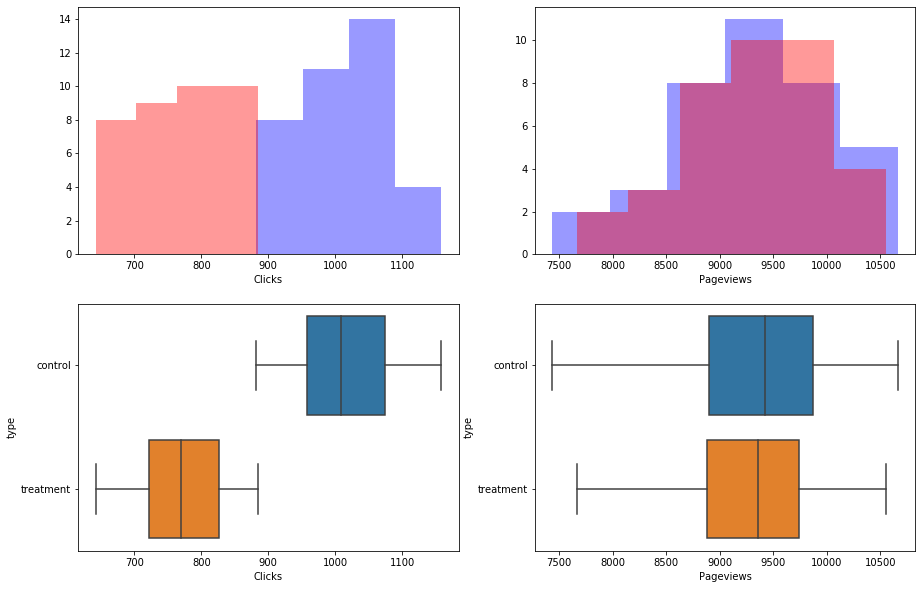

In [11]:
# Visualisasi countplot dan boxplot dari Pageviews dan Clicks
# berdasarkan masing-masing type (Control atau treatment) 
f=plt.figure(figsize=(15,10))

# Distplot dari Clicks
f.add_subplot(2,2,1)
df = dataset[dataset.type == 'control']
sns.distplot(df['Clicks'],  kde=False, color='blue', label='control')
df = dataset[dataset.type == 'treatment']
sns.distplot(df['Clicks'],  kde=False, color='red', label='treatment')

# Distplot dari Pageviews
f.add_subplot(2,2,2)
df = dataset[dataset.type == 'control']
sns.distplot(df['Pageviews'],  kde=False, color='blue', label='control')
df = dataset[dataset.type == 'treatment']
sns.distplot(df['Pageviews'],  kde=False, color='red', label='treatment')

# Boxplot dari Clicks
f.add_subplot(2,2,3)
sns.boxplot(dataset['Clicks'],y=dataset['type'])

# Boxplot dari Pageviews
f.add_subplot(2,2,4)
sns.boxplot(dataset['Pageviews'],y=dataset['type'])

**Distplot & Boxplot Features Clicks** <br>
Dari gambar 1 dan gambar 3 dapat dilihat bahwa distribusi antara control dan treatment berbeda. Nilai dari data control seluruhnya lebih besar daripada nilai data treatment. Artinya dapat diduga bahwa respon pengunjung terhadap control lebih baik daripada treatment sehingga website yang sudah ada lebih baik daripada website yang baru. Hal ini tentunya dapat diartikan bahwa inovasi yang dilakukan masih belum maksimal dan bahkan tidak lebih baik dari sebelumnya.
<br>

**Distplot & Boxplot Features Pageviews** <br>
Dari gambar 2 dan gambar 4 dapat dilihat bahwa distribusi antara control dan treatment mirip. Banyaknya pengunjung dari control dan treatment hampir sama. Secara umum pada treatment hampir mendekati atau sama persis seperti control. Hal ini tentunya dapat diartikan bahwa inovasi yang dilakukan sudah cukup baik namun belum bisa dikatakan lebih baik karena jumlah pengunjung sama seperti pada website control. Namun jika dirasa bahwa website control sudah cukup lama dan dirasa membosankan, maka dapat digantikan dengan website kontrol.

## Z_Test Control dan Treatment

## Import Libraries

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests

## Define Z_Test

Uji-z paling baik digunakan untuk sampel yang lebih besar dari 30. Sebab dalam teorema limit pusat, ketika jumlah sampel bertambah besar, sampel dianggap mendekati distribusi normal.

Uji hipotesis yang akan dilakukan untuk control dan treatment adalah sebagai berikut:

<br>
        H_0    :     P_control == P_treatment <br>
        H_1    :     P_control != P_treatment

In [13]:
def Z_test(data1, data2) :
    
    # menentukan rataan dari feature 1 dan 2
    data1_mean=np.mean(data1)
    data2_mean=np.mean(data2)
    
    # menentukan standard deviasi dari feature 1 dan 2
    data1_std=np.std(data1)
    data2_std=np.std(data2)
    
    # menentukan nilai Z_test dan p-value dari feature 1 dan 2
    ztest ,pval1 = stests.ztest(data1, x2=data2, value=0, alternative='two-sided')
    
    # mendefinisikan decision 1 dan decision 2 untuk analisis Z_test
    decision1 = "reject null hypothesis"
    decision2 = "nont-reject null hypothesis"
    
    # ketika nilai p-value < alfa maka reject H_0, ketika p-value >= alfa maka tidak tolak H_0 
    decision = decision1 if pval1 < 0.05 else decision2
    
    # menampilkan hasil Z_test dalam bentuk DataFrame
    # terdiri atas kolom Data (Control dan Treatment), Mean, Std_dev, Z_score, P_value, dan Desicion
    tabel=pd.DataFrame()
    
    tabel['Data']=['Control','Treatment']
    tabel['Mean']=[data1_mean,data2_mean]
    tabel['Std_dev']=[data1_std,data2_std]
    tabel['Z_score']=[ztest,'']
    tabel['P_value']=[pval1,'']
    tabel['Decision']=[decision,'']
    
    return tabel

### Z_Test Feature Clicks

In [14]:
Z_test(control['Clicks'],treatment['Clicks']).round(2)

,Data,Mean,Std_dev,Z_score,P_value,Decision
0,Control,1016.97,67.36,16.2726,1.54452e-59,reject null hypothesis
1,Treatment,765.54,63.70,,,


Dari hasil uji Z untuk feature Clicks didapat kesimpulan "reject null hypothesis". Artinya tidak benar bahwa proporsi dari control dan treatment sama. Sehingga dapat dikatakan bahwa website treatment dapat dikatakan tidak mampu menggantikan website control. Dengan menggunakan website treatment tidak akan membuat performa website akan menjadi lebih baik (tidak akan lebih diminati). Sehingga inovasi yang dibuat perlu ditingkatkan lagi agar memberikan performa yang setidaknya sama dengan website control. Hal ini tentunya membuktikan dugaan yang didapat dari distplot dan boxplot feature Clicks.

### Z_Test Feature Pageviews

In [15]:
Z_test(control['Pageviews'],treatment['Pageviews']).round(2)

,Data,Mean,Std_dev,Z_score,P_value,Decision
0,Control,9339.00,730.17,0.141712,0.887308,nont-reject null hypothesis
1,Treatment,9315.14,698.44,,,


Dari hasil uji Z untuk features Pageviews didapat kesimpulan "not-reject null hypothesis". Artinya dapat dikatakan bahwa proporsi dasi control dan treatment sama. Sehingga dapat dikatakan bahwa website treatment dapat dikatakan mampu menggantikan website control. Dengan menggunakan website treatment dapat memebrikan performa yang setidaknya sama dengan website control. Hal ini dapat dilakukan jika website control sudah terlalu lama dan bisa jadi ada indikasi bahwa pengunjung akan mulai bosan. Dengan digantikannya oleh websote treatment setidaknya tidak akan menurunkan performa dan ada kemungkinan nantinya akan menaikkan performa karena mengunjung merasa lebih fresh dengan tampilan yang baru. Hal ini tentunya membuktikan dugaan yang didapat dari distplot dan boxplot feature Pageviews.

## Conclusion

Dari kedua features di atas dapat disimpulkan bahwa Clicks memiliki pengaruh yang lebih kuat terhadap performa dari control dan treatment. Dari hasil treatment yang dilakukan terhadap website dapat memberikan performa yang setidaknya sama dengan website control. Sehingga jika dirasa bahwa website control sudah cukup lama digunakan, maka websote treatment dapat menjadi opsi untuk memberikan nuansa baru. Dengan perubahan tersebut setidaknya tidak akan menurunkan performa dan bisa jadi akan menambah performa yang sudah ada. Sebab dengan nuansa baru bisa jadi akan menarik minat pengunjung/pengguna.